<a href="https://colab.research.google.com/github/TytanMikJas/ML-Data-Analysis-Project/blob/main/Stocks_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports:**

In [17]:
## Date conversion
from time import mktime
from datetime import datetime

## Data structures
import pandas as pd

## Scraping
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen
import requests

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Scraping data:

### Code for scraping the historical stock prices data from yahoo finances

In [18]:
# The time between which the data is being scrapped and the interval
start_date = int(mktime(datetime(2020, 3, 1, 23, 59).timetuple()))
end_date = int(mktime(datetime(2023, 3, 1, 23, 59).timetuple()))
interval = '1d' # 1d, 1wk, 1m

# Reading csv from the html query and returning it as pandas dataframe
def get_prices(ticker: str):
    html = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_date}&period2={end_date}&interval={interval}&events=history&includeAdjustedClose=true'
    prices = pd.read_csv(html)
    prices = prices.iloc[:]
    prices.columns = ['Date', 'Open', 'High', 'Low', "Close", 'Adj Close', 'Volume']
    prices = prices.set_index('Date')
    return prices

### Loading up the data for historical pices

saving data in variables and labeling them with ticker

In [19]:
NVDA_prices = get_prices('NVDA').assign(stock='NVDA')
AMD_prices = get_prices('AMD').assign(stock='AMD')
VUG_prices = get_prices('VUG').assign(stock='VUG')

adding the "% change" collumn for each stock that is calculated based on the difference between current and the day before's closing price

In [20]:
NVDA_prices['% change'] = NVDA_prices['Close'].pct_change() * 100
AMD_prices['% change'] = AMD_prices['Close'].pct_change() * 100
VUG_prices['% change'] = VUG_prices['Close'].pct_change() * 100

concatinating all the stocks into one dataframe

In [21]:
stocks_prices = [NVDA_prices, AMD_prices, VUG_prices]
stocks_prices = pd.concat(stocks_prices)
stocks_prices

,Open,High,Low,Close,Adj Close,Volume,stock,% change
Date,,,,,,,,
2020-03-02,69.224998,69.397499,65.250000,69.107498,68.891396,89074400,NVDA,NaN
2020-03-03,69.667503,70.267502,65.614998,66.472504,66.264664,65279200,NVDA,-3.812892
2020-03-04,67.550003,71.222504,66.800003,71.127502,70.905098,59740800,NVDA,7.002893
2020-03-05,69.125000,70.800003,67.875000,68.322502,68.108864,54032800,NVDA,-3.943622
2020-03-06,66.519997,67.097504,64.500000,66.510002,66.302040,51541200,NVDA,-2.652860
...,...,...,...,...,...,...,...,...
2023-02-23,235.240005,235.500000,231.250000,234.539993,233.772583,774000,VUG,0.834044
2023-02-24,230.679993,231.229996,229.080002,230.529999,229.775711,705900,VUG,-1.709727
2023-02-27,232.919998,234.050003,231.580002,232.149994,231.390411,752400,VUG,0.702726


### Code for scraping the insider trading data from finviz

In [22]:
def get_insider(symbol: str):
    url = ("http://finviz.com/quote.ashx?t=" + symbol.lower())
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    html = soup(webpage, "html.parser")

    try:
        insider = pd.read_html(str(html), attrs = {'class': 'body-table'})[0]

        insider = insider.iloc[1:]
        insider.columns = ['Trader', 'Relationship', 'Date', 'Transaction', 'Cost', 'Shares', 'Value', 'Shares Total', 'SEC Form 4']

        insider = insider.set_index('Date')
        return insider

    except Exception as e:
        return e

### Loading up the data for insider tradings

saving data in variables and labeling them with ticker and concatinating all the stocks into one dataframe


In [23]:
NVDA_insider = get_insider('NVDA').assign(stock='NVDA')
AMD_insider = get_insider('AMD').assign(stock='AMD')
stocks_insiders = [NVDA_insider, AMD_insider]
stocks_insiders = pd.concat(stocks_insiders)

adding the needed information, as the insider trades data does not include a valid date (MM-DD format) we change it into a valid (YYYY-MM-DD) one that is corespondant with previous dataframe's data column

In [24]:
current_year = pd.Timestamp.today().year
stocks_insiders.index = pd.to_datetime(stocks_insiders.index + ' ' + str(current_year))
stocks_insiders.index = stocks_insiders.index.where(stocks_insiders.index.month <= 5, stocks_insiders.index - pd.DateOffset(years=1))

# Data analisys

The 'prices' data consists of 7 columns:
1.   Date: The market opening date.
2.   Open: Stock price at the opening time.
3.   High: Highest price observed during the day.
4.   Low: Lowest price observed during the day.
5.   Close: Stock price at the closing time.
6.   Adj Close: Adjusted closing price accounting for splits and dividends.
7.   Volume: Amount of stock traded on that day.
8.   % change - percentage difference in price compared to the day before

In [25]:
stocks_prices.head()

,Open,High,Low,Close,Adj Close,Volume,stock,% change
Date,,,,,,,,
2020-03-02,69.224998,69.397499,65.250000,69.107498,68.891396,89074400,NVDA,NaN
2020-03-03,69.667503,70.267502,65.614998,66.472504,66.264664,65279200,NVDA,-3.812892
2020-03-04,67.550003,71.222504,66.800003,71.127502,70.905098,59740800,NVDA,7.002893
2020-03-05,69.125000,70.800003,67.875000,68.322502,68.108864,54032800,NVDA,-3.943622
2020-03-06,66.519997,67.097504,64.500000,66.510002,66.302040,51541200,NVDA,-2.652860


The 'prices' data consists of 9 columns:
1.   Date: Date of the trade.
2.   Trader: Full name of the trader.
3.   Relationship: Traders position in the company.
4.   Transaction: Type of transaction.
5.   Cost: Number of dolars that the trade cost.
6.   Shares: Number of shares traded.
7.   Value: Value of the shares (shares*cost).
8.   Shares total: the total number of shares owned by trader
9.   SEC Form 4: Date of filling the legal documentation of trade


In [26]:
AMD_insider.head()

,Trader,Relationship,Transaction,Cost,Shares,Value,Shares Total,SEC Form 4,stock
Date,,,,,,,,,
Jul 12,PENG VICTOR,"President, AMD",Option Exercise,0.00,30491,0,30491,Jul 14 04:09 PM,AMD
Jul 06,Papermaster Mark D,Chief Technology Officer & EVP,Option Exercise,6.98,31701,221273,1544946,Jul 10 04:26 PM,AMD
Jul 06,Papermaster Mark D,Chief Technology Officer & EVP,Sale,111.49,31701,3534376,1513245,Jul 10 04:26 PM,AMD
Jun 09,WOLIN HARRY A,"SVP, GC & Corporate Secretary",Option Exercise,17.27,74473,1286225,1499337,Jun 13 05:33 PM,AMD
Jun 09,PENG VICTOR,"President, AMD",Sale,124.57,105000,13080128,321090,Jun 13 05:31 PM,AMD


### Checking for missing data

In [27]:
print("Stock prices history potentially missing data:")
print(stocks_prices.isna().sum())

print("\nStock insider trades potentially missing data:")
print(stocks_insiders.isna().sum())

Stock prices history potentially missing data:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
stock        0
% change     3
dtype: int64

Stock insider trades potentially missing data:
Trader          0
Relationship    0
Transaction     0
Cost            0
Shares          0
Value           0
Shares Total    0
SEC Form 4      0
stock           0
dtype: int64


### Missing data - conclusions
The '% change' column calculates the percentage difference in price compared to the previous day. Since it is not possible to calculate the difference for the first day in the dataset and the day before it, it becomes necessary to fill in the missing data. The most appropriate approach is to fill it with '0%', as there is no change between the first day and the non-existent day in the stock market.

In [28]:
stocks_prices['% change'] = stocks_prices['% change'].fillna(0)

# Graphical analisys of data with Dependencies between data

### The plot displays price history of each invidiual stock over 3 years period.

This plot allows us to delve into the details and overall analisys of the scrapped stock prices data

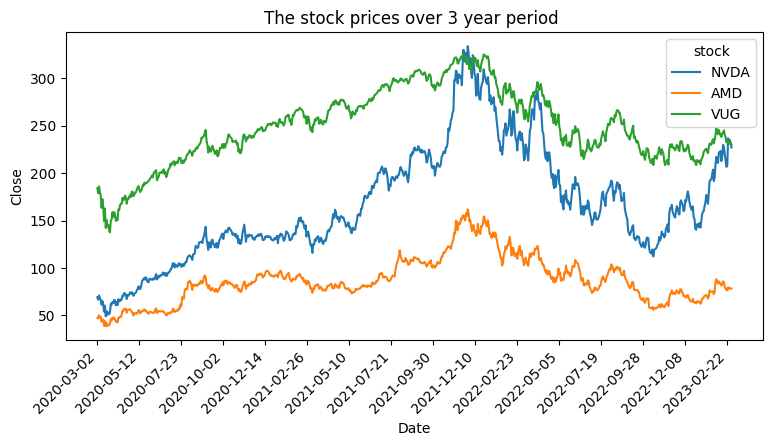

In [29]:
plt.figure(figsize=(9, 4))
sns.lineplot(data=stocks_prices, x='Date', y='Close', hue='stock')
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.title('The stock prices over 3 year period ')
plt.show()

## The plot displays change of value of our investment if we decided to place 100$ in each of the stocks in dataset

There are several correlations that we can draw from the graph:

*   Nvidia is clearly the strongest stock. It's also very fragile to fluctuations, therefore we can concider it the riskiest ivestment among dataset. Quite simmilar dependecie  goes for AMD as lesser, but notable fluctiuations can be noted on the graph

*   Nvidia seems to be strongly corelated with AMD. The difference is in the value, but it's perfectly normal, as Nvidia is more prone to fluctuations, therefore whenever AMD moves 1% on Y axis, Nvidia tends to move 1.5 times the percentage amount.


**The most importand and unfortunate aspect being the fact that the data does not indicate any particular pattern. At this point it becomes noticable that creating a valid model would be close to imposible.**

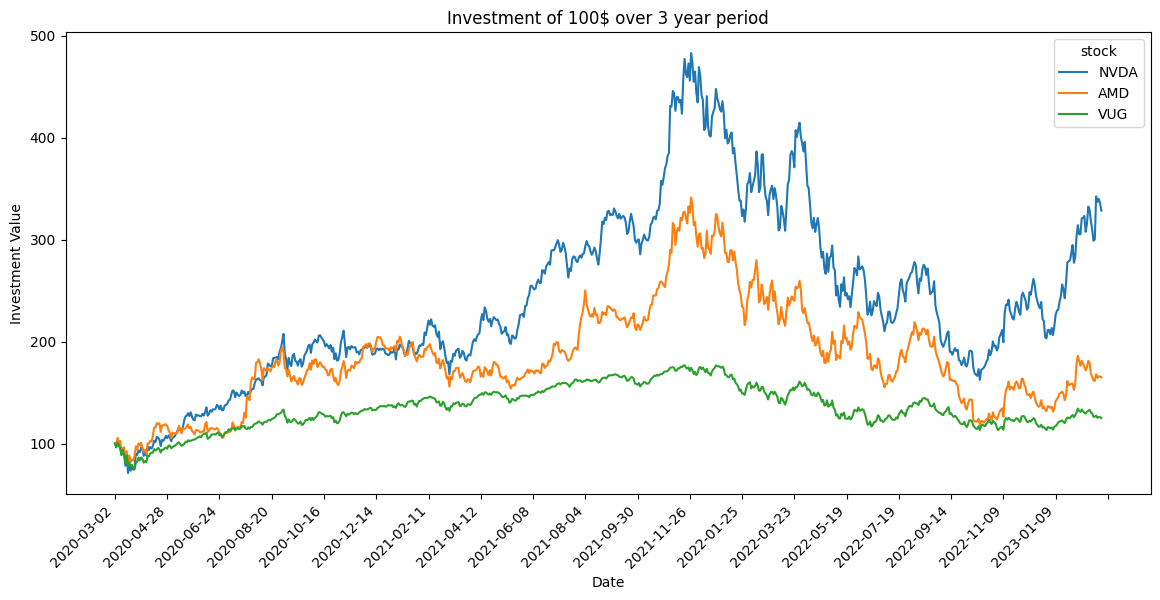

In [30]:
temp = stocks_prices
temp['Investment Value'] = temp.groupby('stock')['Close'].transform(lambda x: (100 * (x / x.iloc[0])))

plt.figure(figsize=(14, 6))
sns.lineplot(data=temp, x='Date', y='Investment Value', hue='stock')
plt.xticks(rotation=45, ha='right')

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(25))

plt.title('Investment of 100$ over 3 year period')
plt.show()

## The plot displays number of insider trades performed by each company, distingushing the Option Excercises and Sales.

It's noticable that AMD and NVDA performed very simmilar amounts of Sales of their insiders stocks, although a complete opposite is displayed when it comes to Option Execises. Those were mostly performed by AMD insiders.

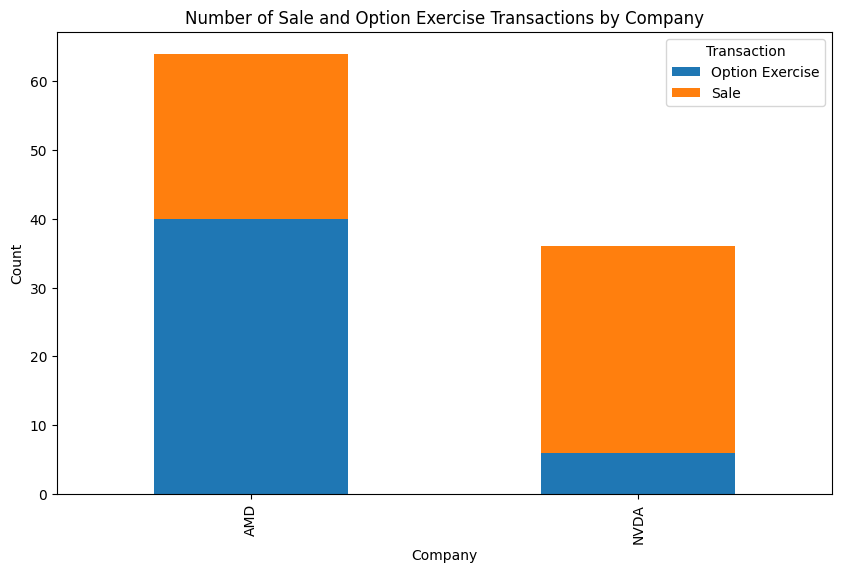

In [31]:
transaction_counts = stocks_insiders.groupby(['stock', 'Transaction']).size().unstack().fillna(0)

transaction_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Company')
plt.ylabel('Count')
plt.title('Number of Sale and Option Exercise Transactions by Company')

plt.show()

## The plot displays Nnvidia's insider trades (Option exercises and Sales) over the last year. It is noticable that in the first half of the plot the insiders had tendencies to Option Exercise in the drops. The oposite is noticable for sales, which were performed mostly at the time where the stock was soaring.

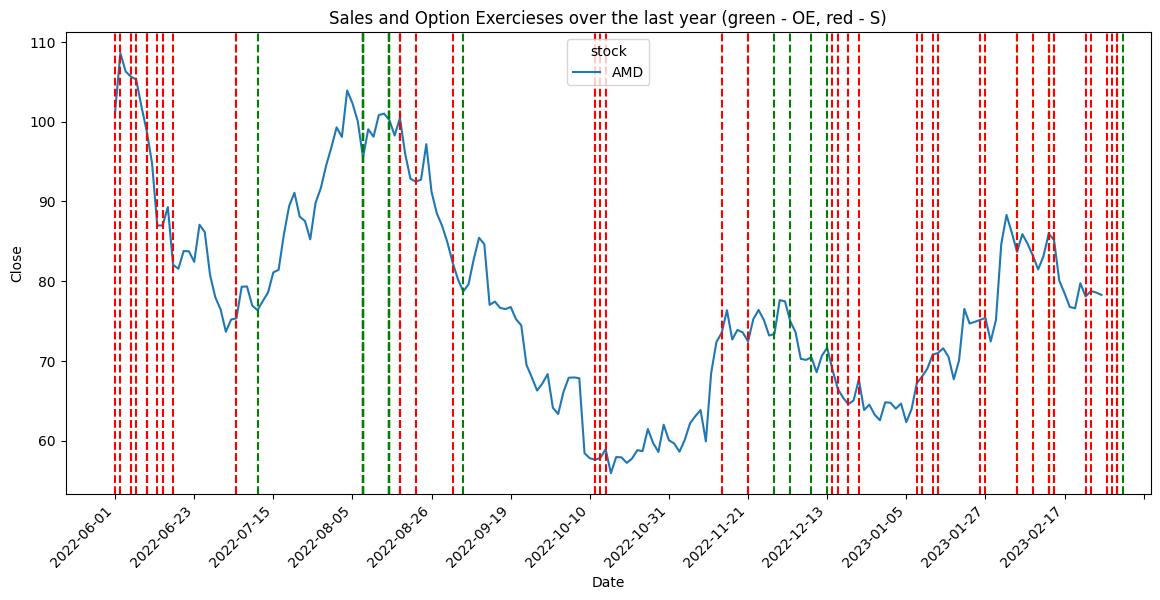

In [32]:
# Convert index to DatetimeIndex and then convert to string
AMD_prices.index = pd.to_datetime(AMD_prices.index)
AMD_prices['Date'] = AMD_prices.index.strftime('%Y-%m-%d')

start_date = '2022-06-01'
AMD_prices_filtered = AMD_prices[AMD_prices['Date'] >= start_date]

insider_cutoff_date = '2023-03-05'
stocks_insiders_filtered = stocks_insiders[stocks_insiders.index < insider_cutoff_date]

plt.figure(figsize=(14, 6))
sns.lineplot(data=AMD_prices_filtered, x='Date', y='Close', hue='stock')

for index, row in stocks_insiders_filtered.iterrows():
    date = index.strftime('%Y-%m-%d')
    company = row['stock']
    transaction = row['Transaction']

    if transaction == 'Sale':
        plt.axvline(x=date, color='red', linestyle='--')
    else:
        plt.axvline(x=date, color='green', linestyle='--')

plt.xticks(rotation=45, ha='right')

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.title('Sales and Option Exercieses over the last year (green - OE, red - S)')
plt.show()

# **THE UNFORTUNATE END OF THE PROJECT**
The data of stocks_prices that I have managed to scrap using API and the data of insiders_trades that i have manualy scrapped unfortunatelly does not allow me to continue the jurney of fullfiling the project's goal. It does not indicate any patters. It is simmilar to random, if we look at it as we were a computer. Creating a predicting model on this dataset is like divination from a crystal sphere

## In this part, I have managed to:
* Scrape two different pieces of data from two different sites for three different stocks.
* Perform pre-processing and add columns to the data.
* Fill the missing data in the dataframes.
* Perform data analysis.
* Create some interesting graphs to further analyze the data and search for correlations (not many of them, as it quickly became noticeable that there is no point in continuing the plotting, as the project would be abandoned).




# The pivot towards the Netflix dataset
As I (hopefuly) have menaged to exhaustively shown my skills of scrapping, analysing the data obtained, pre-processing (adding and filling the datasets) and displaying the data in interesting way. I have decided to move towards a different problem in which I will skip the first part of scraping the data as I hopefully have managed to prove that I'm capable of exhaustively performing it